# TD 4 - 27/03/20 - Simulation et Monte Carlo

- **Exercice 7 :** MCMC
- **Exercice 6 :** Importance sampling
- **Option :** cross-entropy

## Exercice 7 : MCMC (Markov chain Monte Carlo)

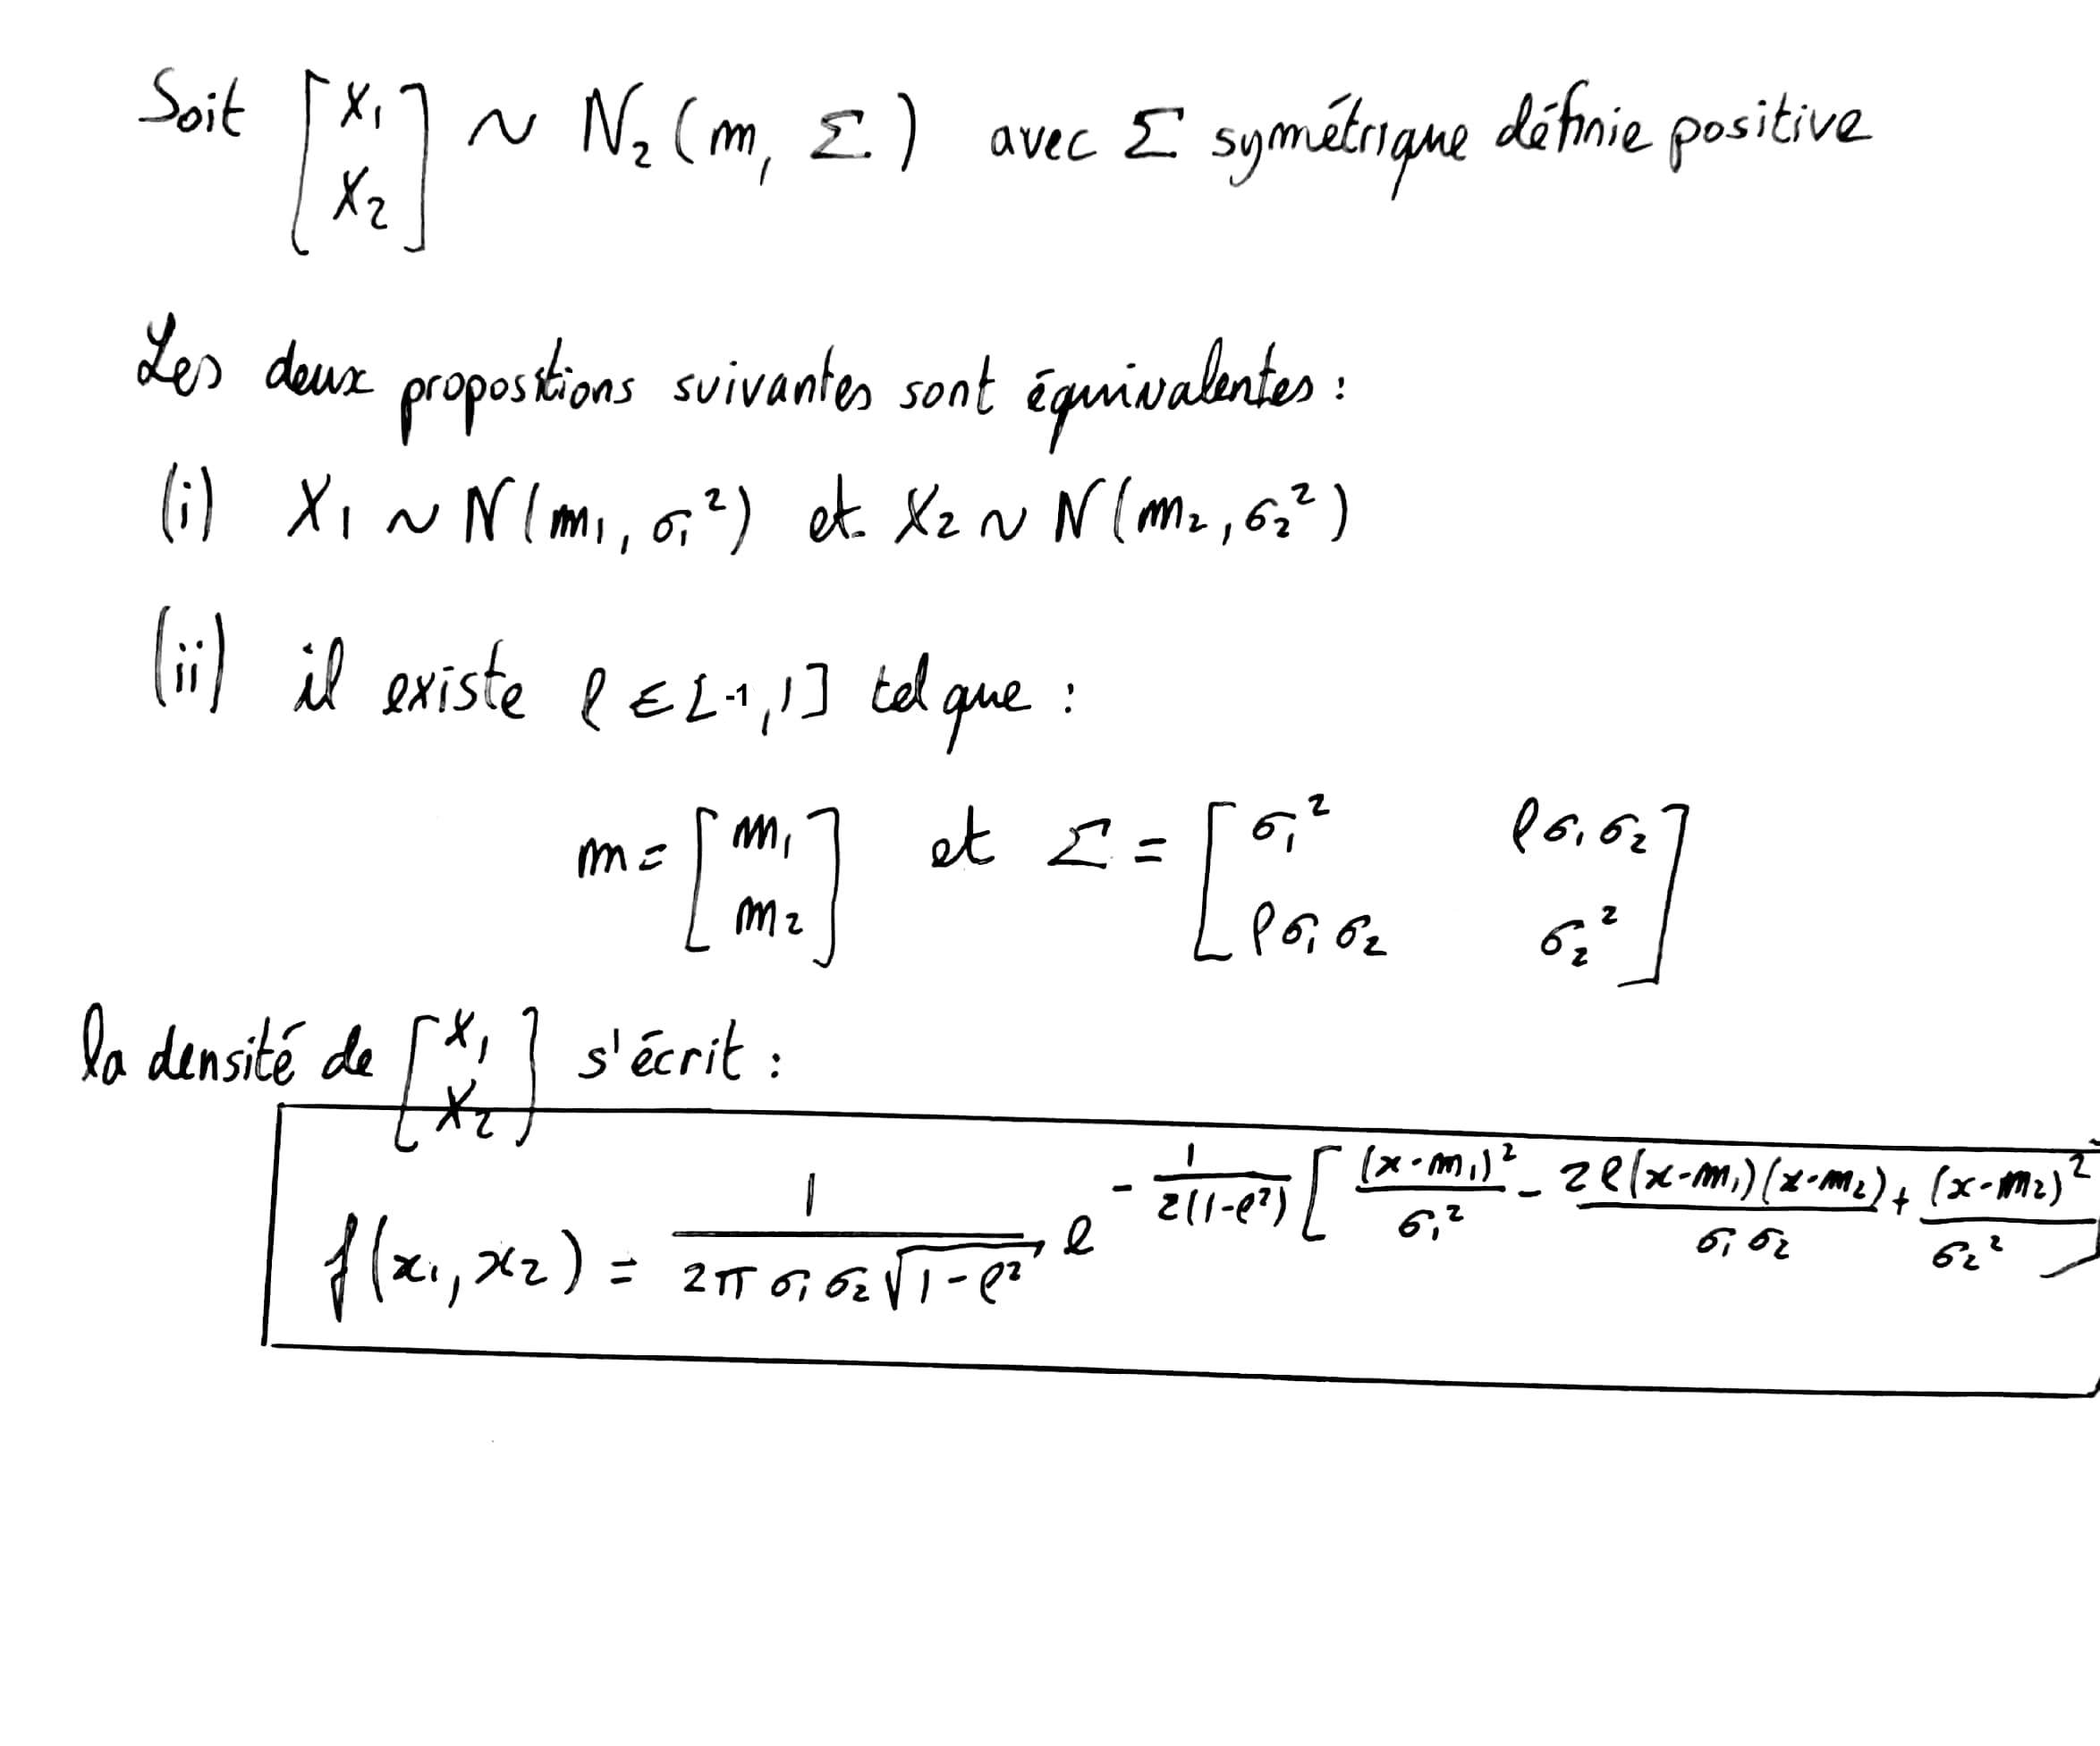

### 7.1.

- quelle loi reconnaissez-vous ?

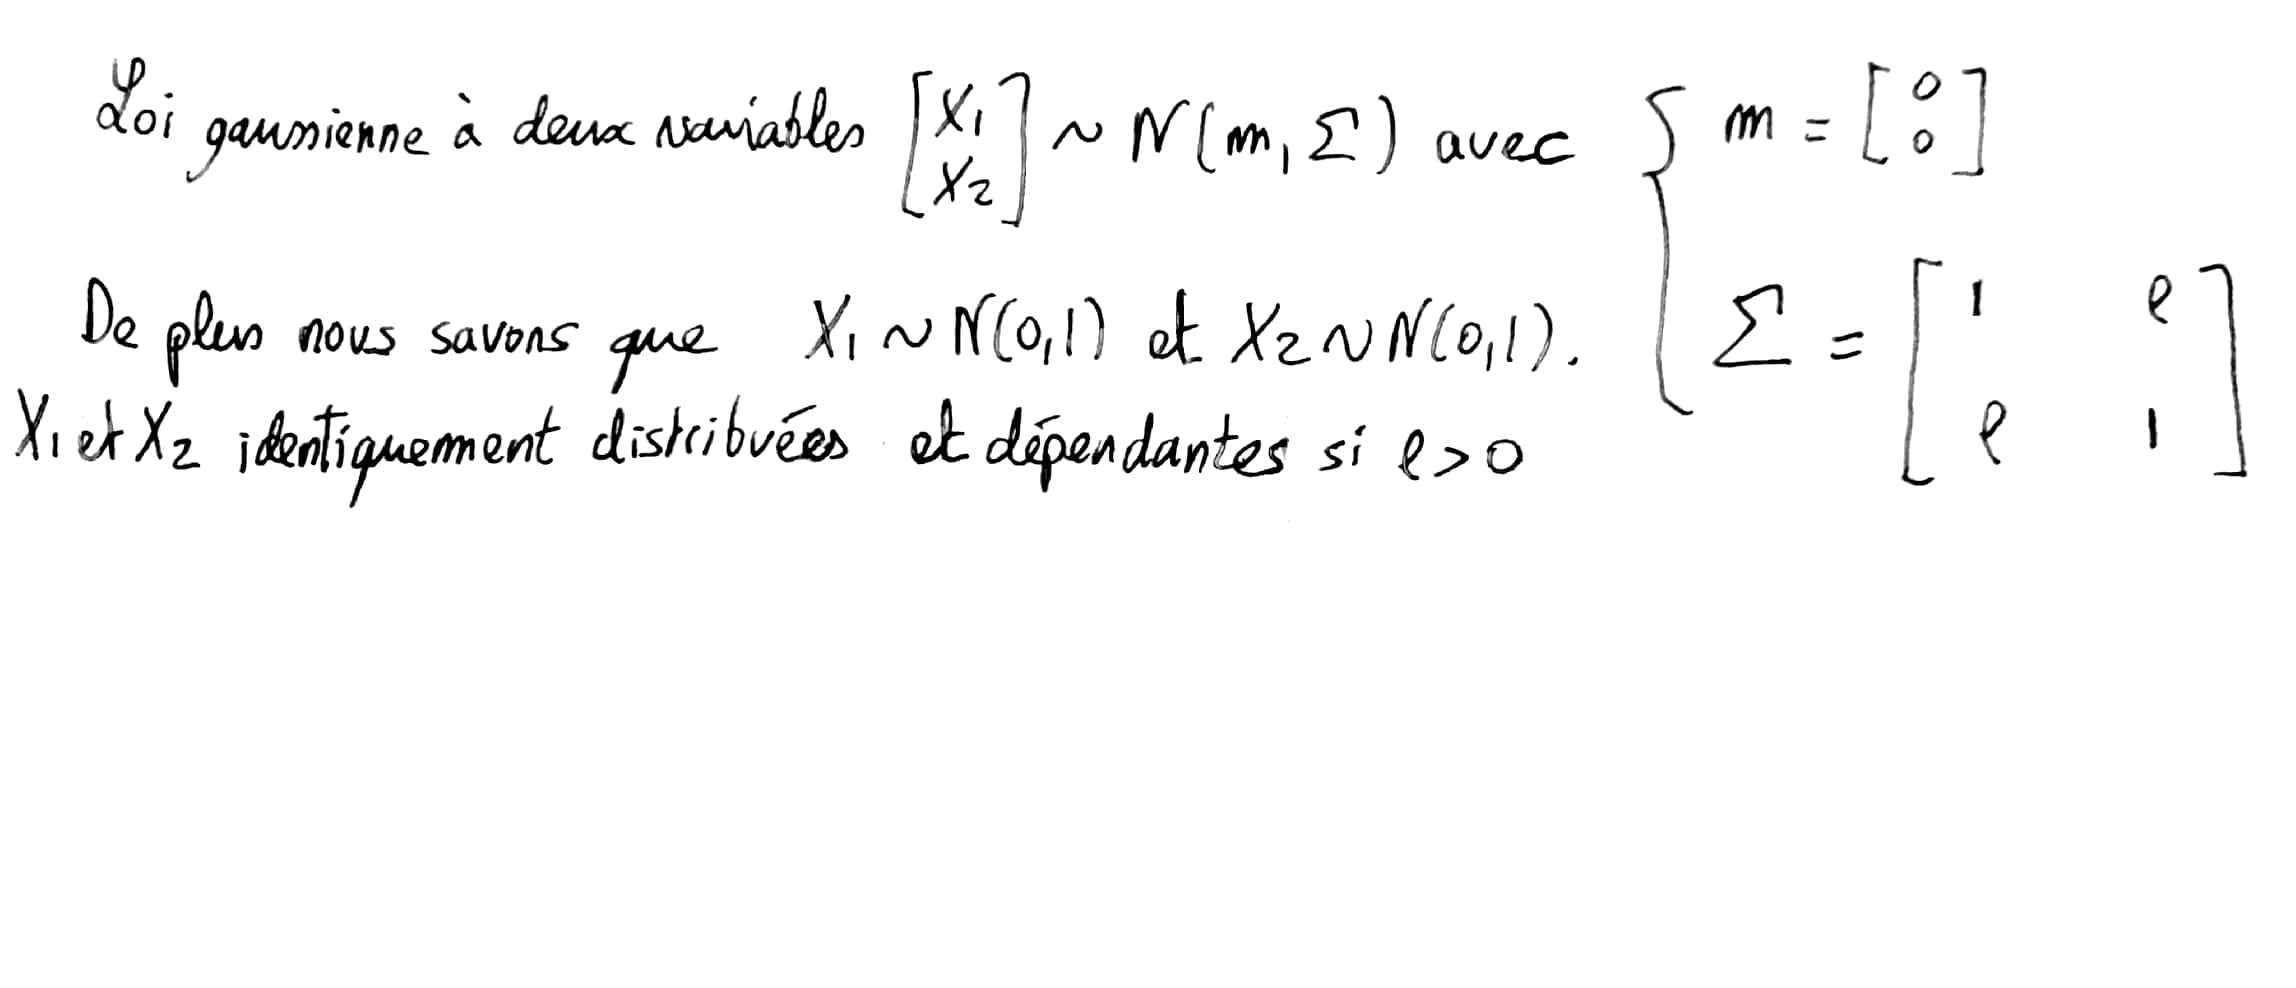

### 7.2.

- Calculer les **lois conditionnelles** de chaque composante

- Mettre en oeuvre le **Gibbs sampler** correspondant

**code R :**

In [1]:
library("mvtnorm")

rand_gauss_gibbs <- function(n, rho){
    X1 = rep(0, n)
    X2 = rep(0, n)
      
    # initialisation : nous pouvons choisir autre valeur
    X2[1] = 0
    
    # itération gibbs sampler
    for (t in (1:(n-1))){
      X1[t] = rnorm(1, rho*X2[t], sqrt(1-rho^2))
      X2[t+1] = rnorm(1, rho*X1[t], sqrt(1-rho^2))
    }
      
    # ne pas oublier la dernière simulation de X1
    X1[n] = rnorm(1,rho*X2[n],sqrt(1-rho^2))
    
    return(list(X1 = X1,X2 = X2))
}

rn = rand_gauss_gibbs(10, 0.6)
cat("exemple de simulation des v.a")
cat("\n\n- X1 : ", rn$X1)
cat("\n\n- X2 : ", rn$X2)

exemple de simulation des v.a

- X1 :  0.01462753 -0.265645 2.410374 1.700682 0.7669434 -0.8912438 0.2856803 -1.092963 0.5913512 1.343289

- X2 :  0 -1.739623 1.280999 0.1939524 0.7748758 0.6712785 -0.09766843 -0.01011693 0.1951222 1.333276

- Représenter dans le plan : des **contours de la densité cible** et l'**évolution de la chaîne de Markov simulée**

**code R :**

In [2]:
# fonction qui renvoie la densité p(x,y)
binormal <- function(x, y, rho){
    return( dmvnorm(cbind(x, y), rep(0,2), cbind(c(1,rho), c(rho,1)) ) )
}

# fonction qui affiche les contours de la densité cible et l'échantillon simulé
plot_gibbs_contour <- function(n, rho){
    
    # simuler X1 et X2
    rn = rand_gauss_gibbs(n, rho)
    X1 = rn$X1
    X2 = rn$X2
    
    # contours de la densité cible
    x <- seq(min(X1), max(X1), length.out = 100)
    y <- seq(min(X2), max(X2), length.out = 100)
    z <- outer(x, y, binormal, rho = rho)
    contour(x,y,z, nlevels = 15, main = paste("rho = ",rho), xlab = "X1", ylab = "X2")

    # représentation de la chaine de Markov simulée
    points(X1, X2, pch = 20, col = "steelblue")
}

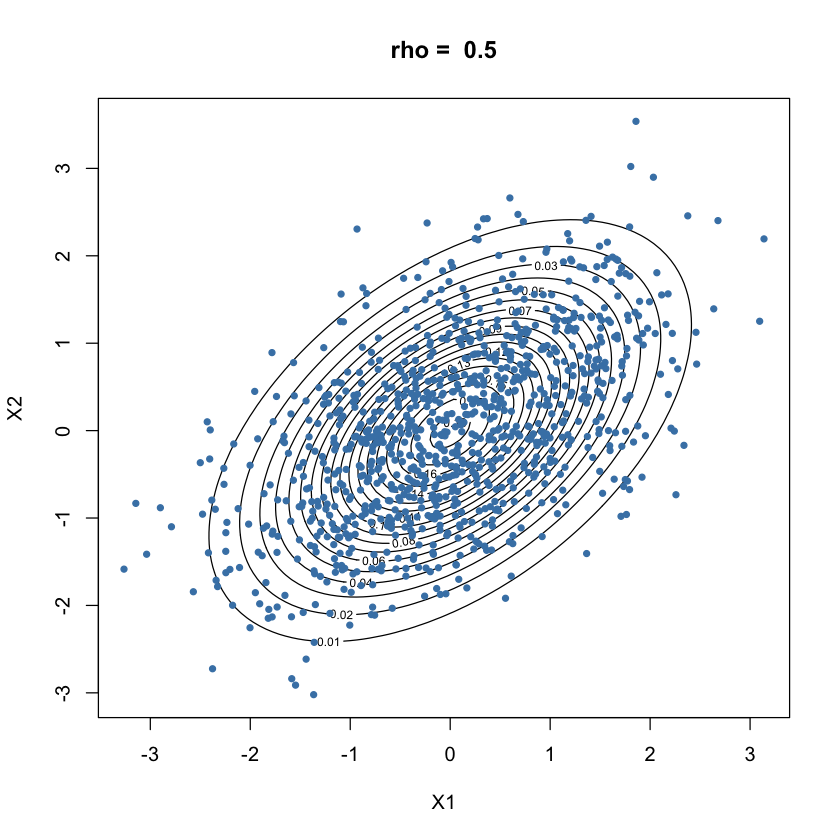

In [3]:
plot_gibbs_contour(n = 1000, rho = 0.5)

- Que se passe-t-il quand $\rho \to 1$ ?

**code R :**

In [4]:
n = 1000
rho <- c(0, 0.2, 0.5, 0.9, 0.99, 0.9999)
par(mfrow=c(2,3))
for(r in rho){
    plot_gibbs_contour(n = n, rho = r)
}

lorsque $\rho \to 1$, $X_2 = X_1$ p.s

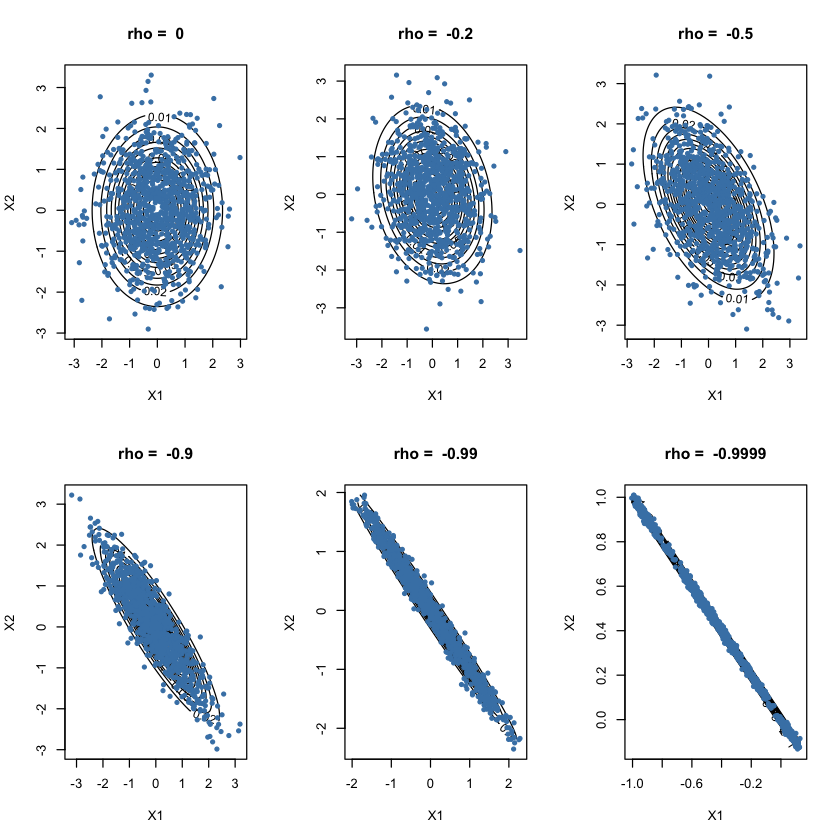

In [5]:
n = 1000
rho_neg <- -rho
par(mfrow=c(2,3))
for(r in rho_neg){
    plot_gibbs_contour(n = n, rho = r)
}

lorsque $\rho \to -1$, $X_2 = -X_1$ p.s

Regardons la trace (ou l'évolution) de $X_1$ et $X_2$ pour $\rho \to 1$.

Nous utilisons le package R [coda](https://cran.r-project.org/web/packages/coda/index.html) qui est connu pour faire analyser du MCMC

**Quelques remarques :**
- les fonctions utilisées peuvent être entièrement recodées
- vous avez beaucoup de packages similaire en python : [pymc](https://pymc-devs.github.io/pymc/modelchecking.html) par exemple

In [39]:
#install.packages("coda")
library("coda") # spécialisé dans les analyses de MCMC

plot_gibbs_density <- function(n, rho){
    # simuler X1 et X2
    rn = rand_gauss_gibbs(n, rho)
    X1 = rn$X1
    X2 = rn$X2
    # plot trace and density
    plot(as.mcmc(cbind(X1, X2)))
}

plot_gibbs_trace <- function(n, rho){
    # simuler X1 et X2
    rn = rand_gauss_gibbs(n, rho)
    X1 = rn$X1
    X2 = rn$X2
    # plot
    traceplot(as.mcmc(cbind(X1, X2)))
}

plot_gibbs_ACF <- function(n, rho){
    # simuler X1 et X2
    rn = rand_gauss_gibbs(n, rho)
    X1 = rn$X1
    X2 = rn$X2
    # plot
    autocorr.plot(as.mcmc(cbind(X1, X2)))
}

- pour $\rho = 0.2$

In [34]:
plot_gibbs_density(n = 1000, rho = 0.2)

- pour $\rho = 0.9$

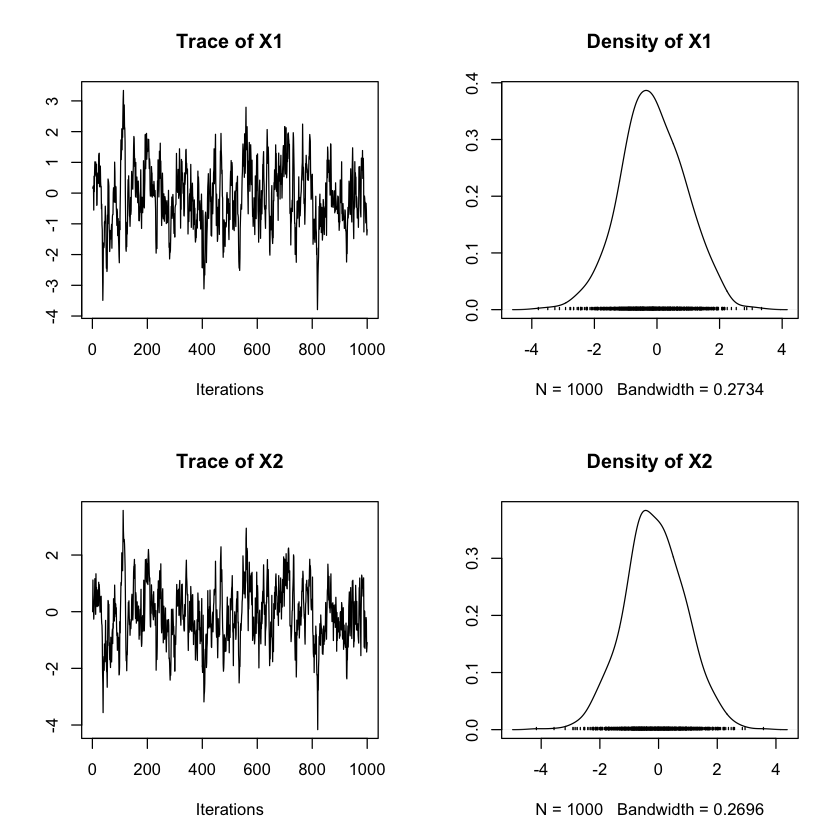

In [35]:
plot_gibbs_density(n = 1000, rho = 0.9)

- pour $\rho = 0.999$

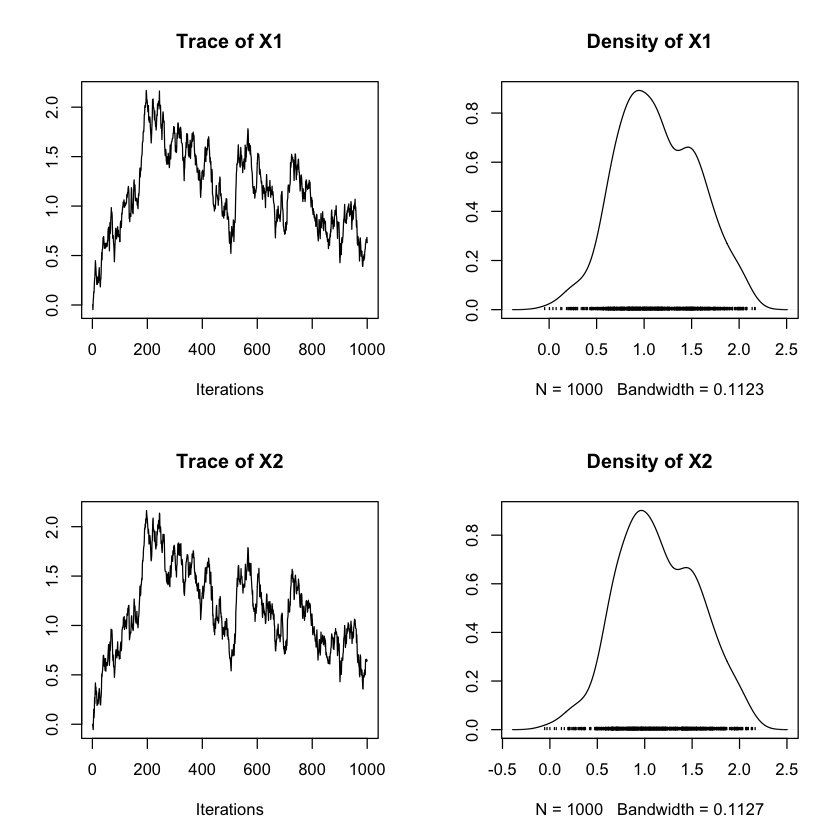

In [36]:
plot_gibbs_density(n = 1000, rho = 0.999)

Par les **trace plot**, nous observons donc des anomalies lorsque $\rho \to 1$

Un autre diagnostic possible est l'utilisation les **fonctions d'auto-correlations** (ACF)

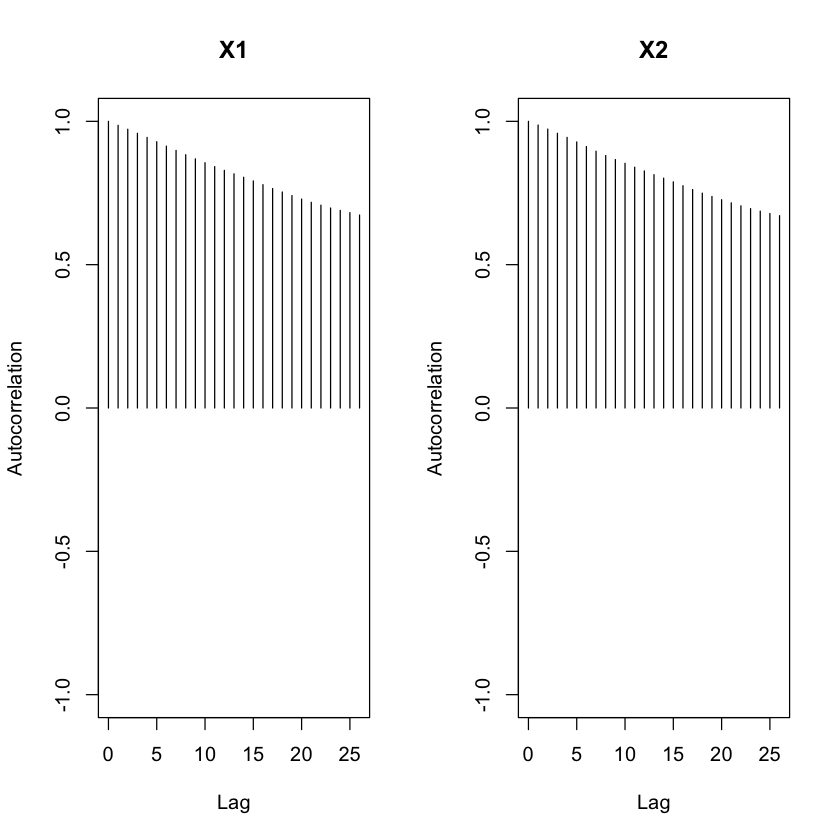

In [40]:
n = 1000
rho <- c(0.2, 0.9, 0.999)
for(r in rho){
    plot_gibbs_ACF(n = n, rho = r)
}

### 7.3.

- Programmer un algorithme **RWHM** (Hastings-Metropolis avec marche aléatoire)

In [61]:
RWMH <- function(n, rho, sigma){

    X <- matrix(0, n, 2)

    for (t in (1:(n-1))){
        
        # proposition
        x = rmvnorm(1, mean=X[t,], sigma=sigma)
        
        if(log(runif(1))<log(dmvnorm(x, mean=rep(0,2), sigma=cbind(c(1,rho),c(rho,1))))-
           log(dmvnorm(X[t,],mean=rep(0,2),sigma=cbind(c(1,rho),c(rho,1))))){
            X[t+1,] = x
        }
        
        else{
            X[t+1,] = X[t,]
        }
    }

    return(list(X1 = X[,1], X2 = X[,2]))
}

In [67]:
n = 10
rho = 0.8
tau = 0.8
X = RWMH(n, rho, tau*diag(2))
X

$X1
 [1]  0.00000000  0.08407134  0.08407134  0.08407134  0.08407134  0.77387579
 [7]  1.52852788 -0.94287926  0.36700040  0.22213499

$X2
 [1]  0.0000000  0.2581721  0.2581721  0.2581721  0.2581721 -0.3752249
 [7]  0.7304893 -0.5873151 -0.7757025 -0.3027794

In [95]:
# fonction qui affiche les contours de la densité cible et l'échantillon simulé
plot_RWHM_contour <- function(n, rho, tau, sigma = diag(2)){
    # simuler X1 et X2
    rn = RWMH(n, rho, tau*sigma)
    X1 = rn$X1
    X2 = rn$X2
    
    # contours de la densité cible
    x <- seq(min(X1), max(X1), length.out = 100)
    y <- seq(min(X2), max(X2), length.out = 100)
    z <- outer(x, y, binormal, rho = rho)
    contour(x,y,z, nlevels = 15, main = paste("rho = ",rho, "; tau = ", tau), xlab = "X1", ylab = "X2")

    # représentation de la chaine de Markov simulée
    points(X1, X2, pch = 20, col = "steelblue")
}

plot_RWHM_density <- function(n, rho, tau, sigma = diag(2)){
    # simuler X1 et X2
    rn = RWMH(n, rho, tau*sigma)
    X1 = rn$X1
    X2 = rn$X2
    # plot trace and density
    plot(as.mcmc(cbind(X1, X2)))
}

plot_RWHM_trace <- function(n, rho, tau, sigma = diag(2)){
    # simuler X1 et X2
    rn = RWMH(n, rho, tau*sigma)
    X1 = rn$X1
    X2 = rn$X2
    # plot
    traceplot(as.mcmc(cbind(X1, X2)))
}

plot_RWHM_ACF <- function(n, rho, tau, sigma = diag(2)){
    # simuler X1 et X2
    rn = RWMH(n, rho, tau*sigma)
    X1 = rn$X1
    X2 = rn$X2
    
    # plot
    autocorr.plot(as.mcmc(cbind(X1, X2)))
}

ci-dessou les paramètres :

In [96]:
tau = c(0.001, 1, 10, 100)
rho = c(0.2, 0.9, 0.999)

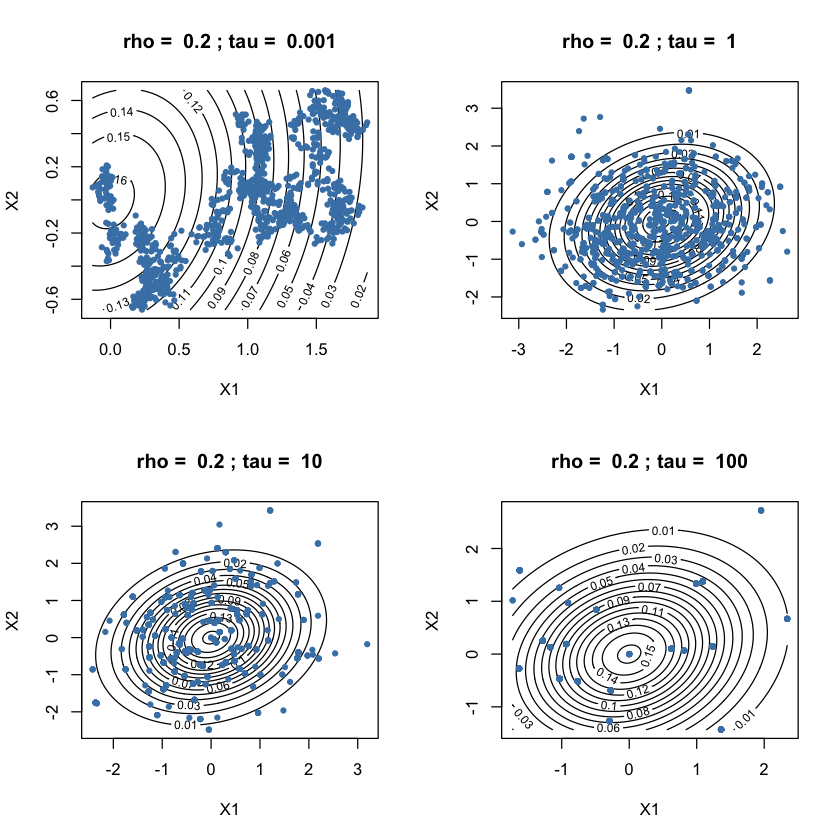

In [97]:
par(mfrow=c(2,2))
for(t in tau){
    plot_RWHM_contour(n = 1000, rho = rho[1], tau = t)
}

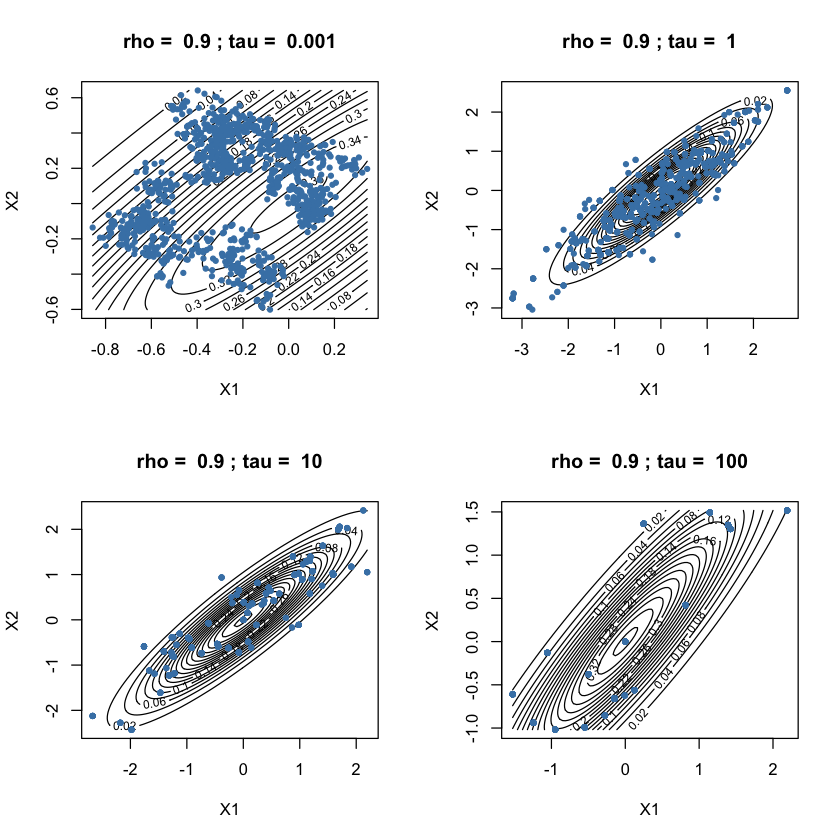

In [82]:
par(mfrow=c(2,2))
for(t in tau){
    plot_RWHM_contour(n = 1000, rho = rho[2], tau = t)
}

In [84]:
par(mfrow=c(2,2))
for(t in tau){
    plot_RWHM_contour(n = 1000, rho = rho[3], tau = t)
}

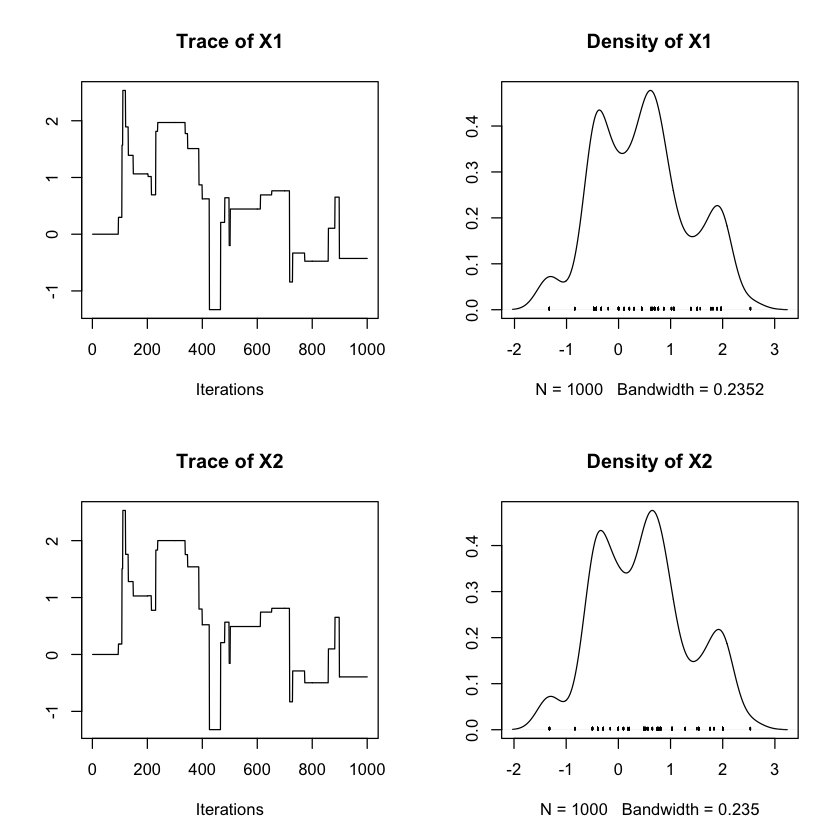

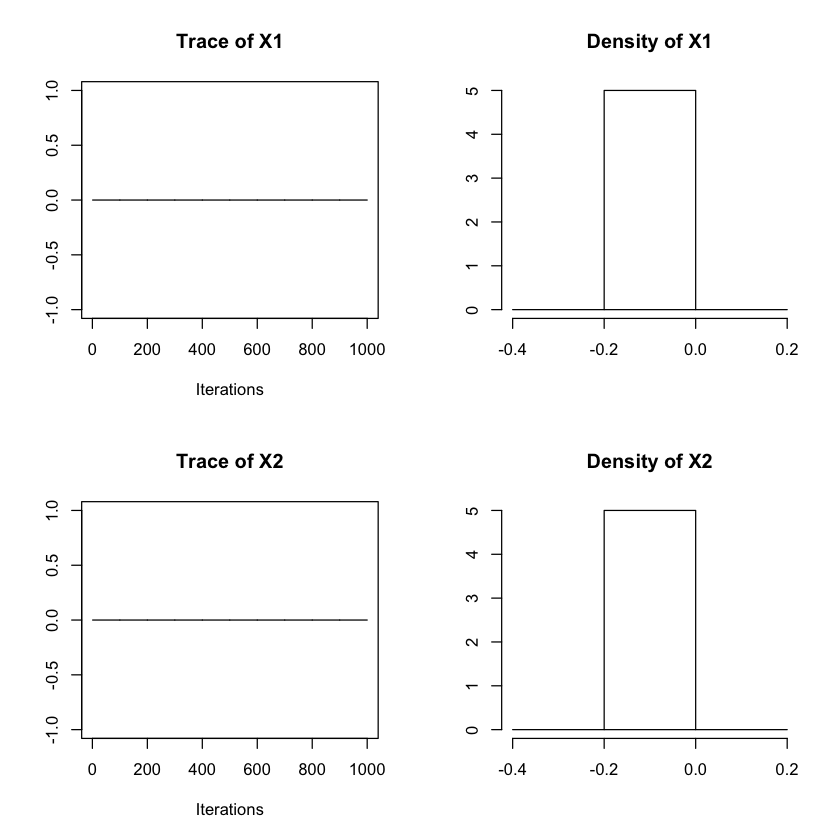

In [87]:
for(t in tau){
    plot_RWHM_density(n = 1000, rho = rho[3], tau = t)
}

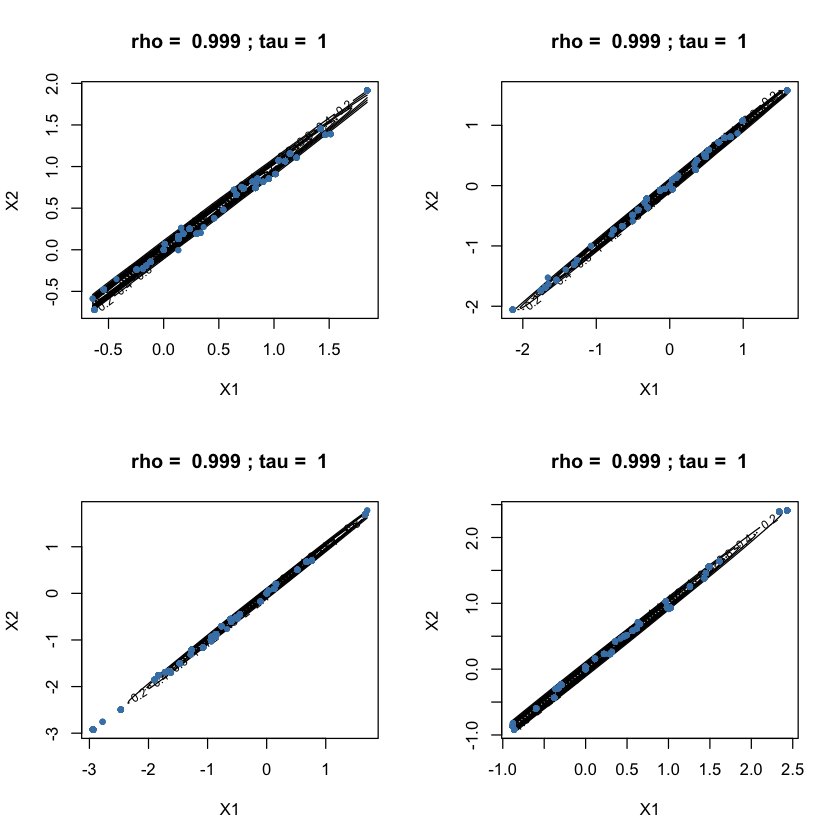

In [109]:
par(mfrow=c(2,2))
for(t in tau){
    plot_RWHM_contour(n = 1000, rho = 0.999, tau = 1)
}

In [110]:
par(mfrow=c(2,2))
for(t in tau){
    plot_RWHM_contour(n = 1000, rho = 0.999, tau = 1, sigma = cbind(c(1,0.999),c(0.999,1)))
}

In [112]:
plot_RWHM_density(n = 1000, rho = 0.999, tau = 1, sigma = cbind(c(1,0.999),c(0.999,1)))

**Résultat des courses :**

1. Gibbs sampling est un bon outil pour construire des chaînes de Markov

1. Cependant lorsque les v.a marginales sont très corrélées ($\rho \to 1$) nous avons des anomalies : loi simulée différente de la loi cible

2. nous pouvons améliorer la performance de la simulation en utilisant un algorithme **RWHM** (où $\Sigma$ de la loi auxilière $\mathcal{N}(m, \Sigma)$ doit être bien choisie, pas "trop grand", pas "trop petit").

## Exercice 6 : Importance sampling (échantillonnage pondérée)

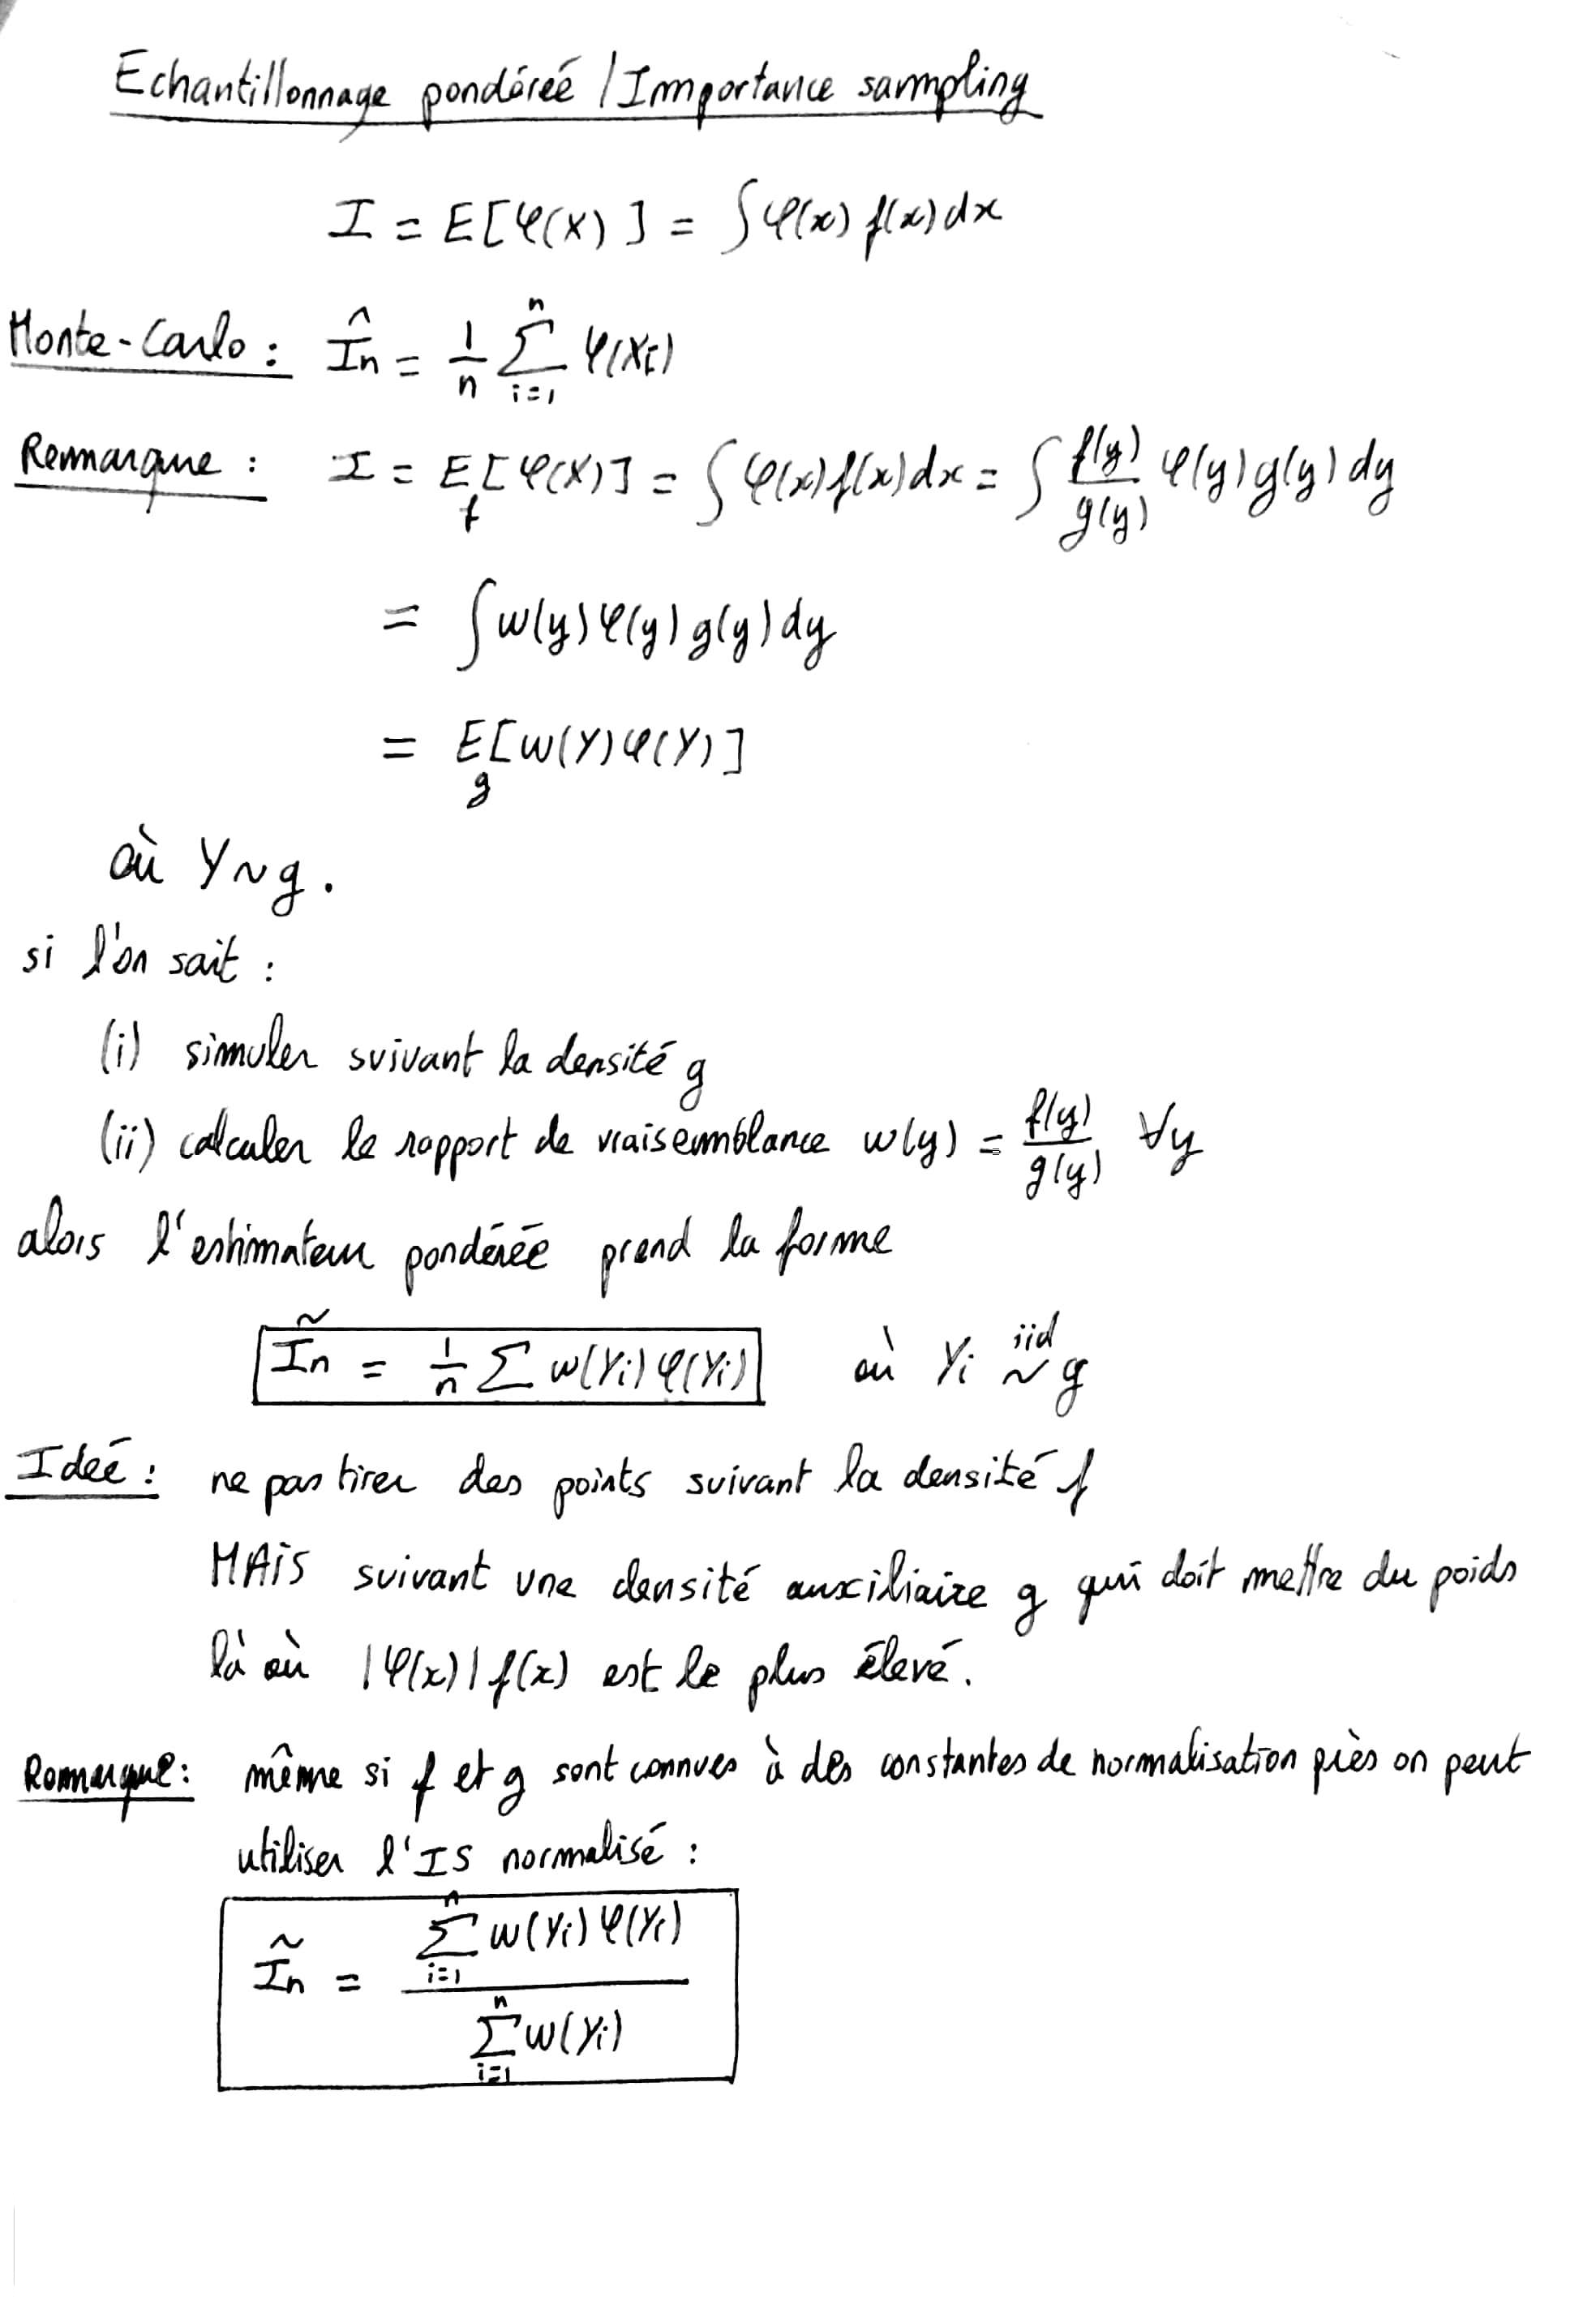

### 6.0.

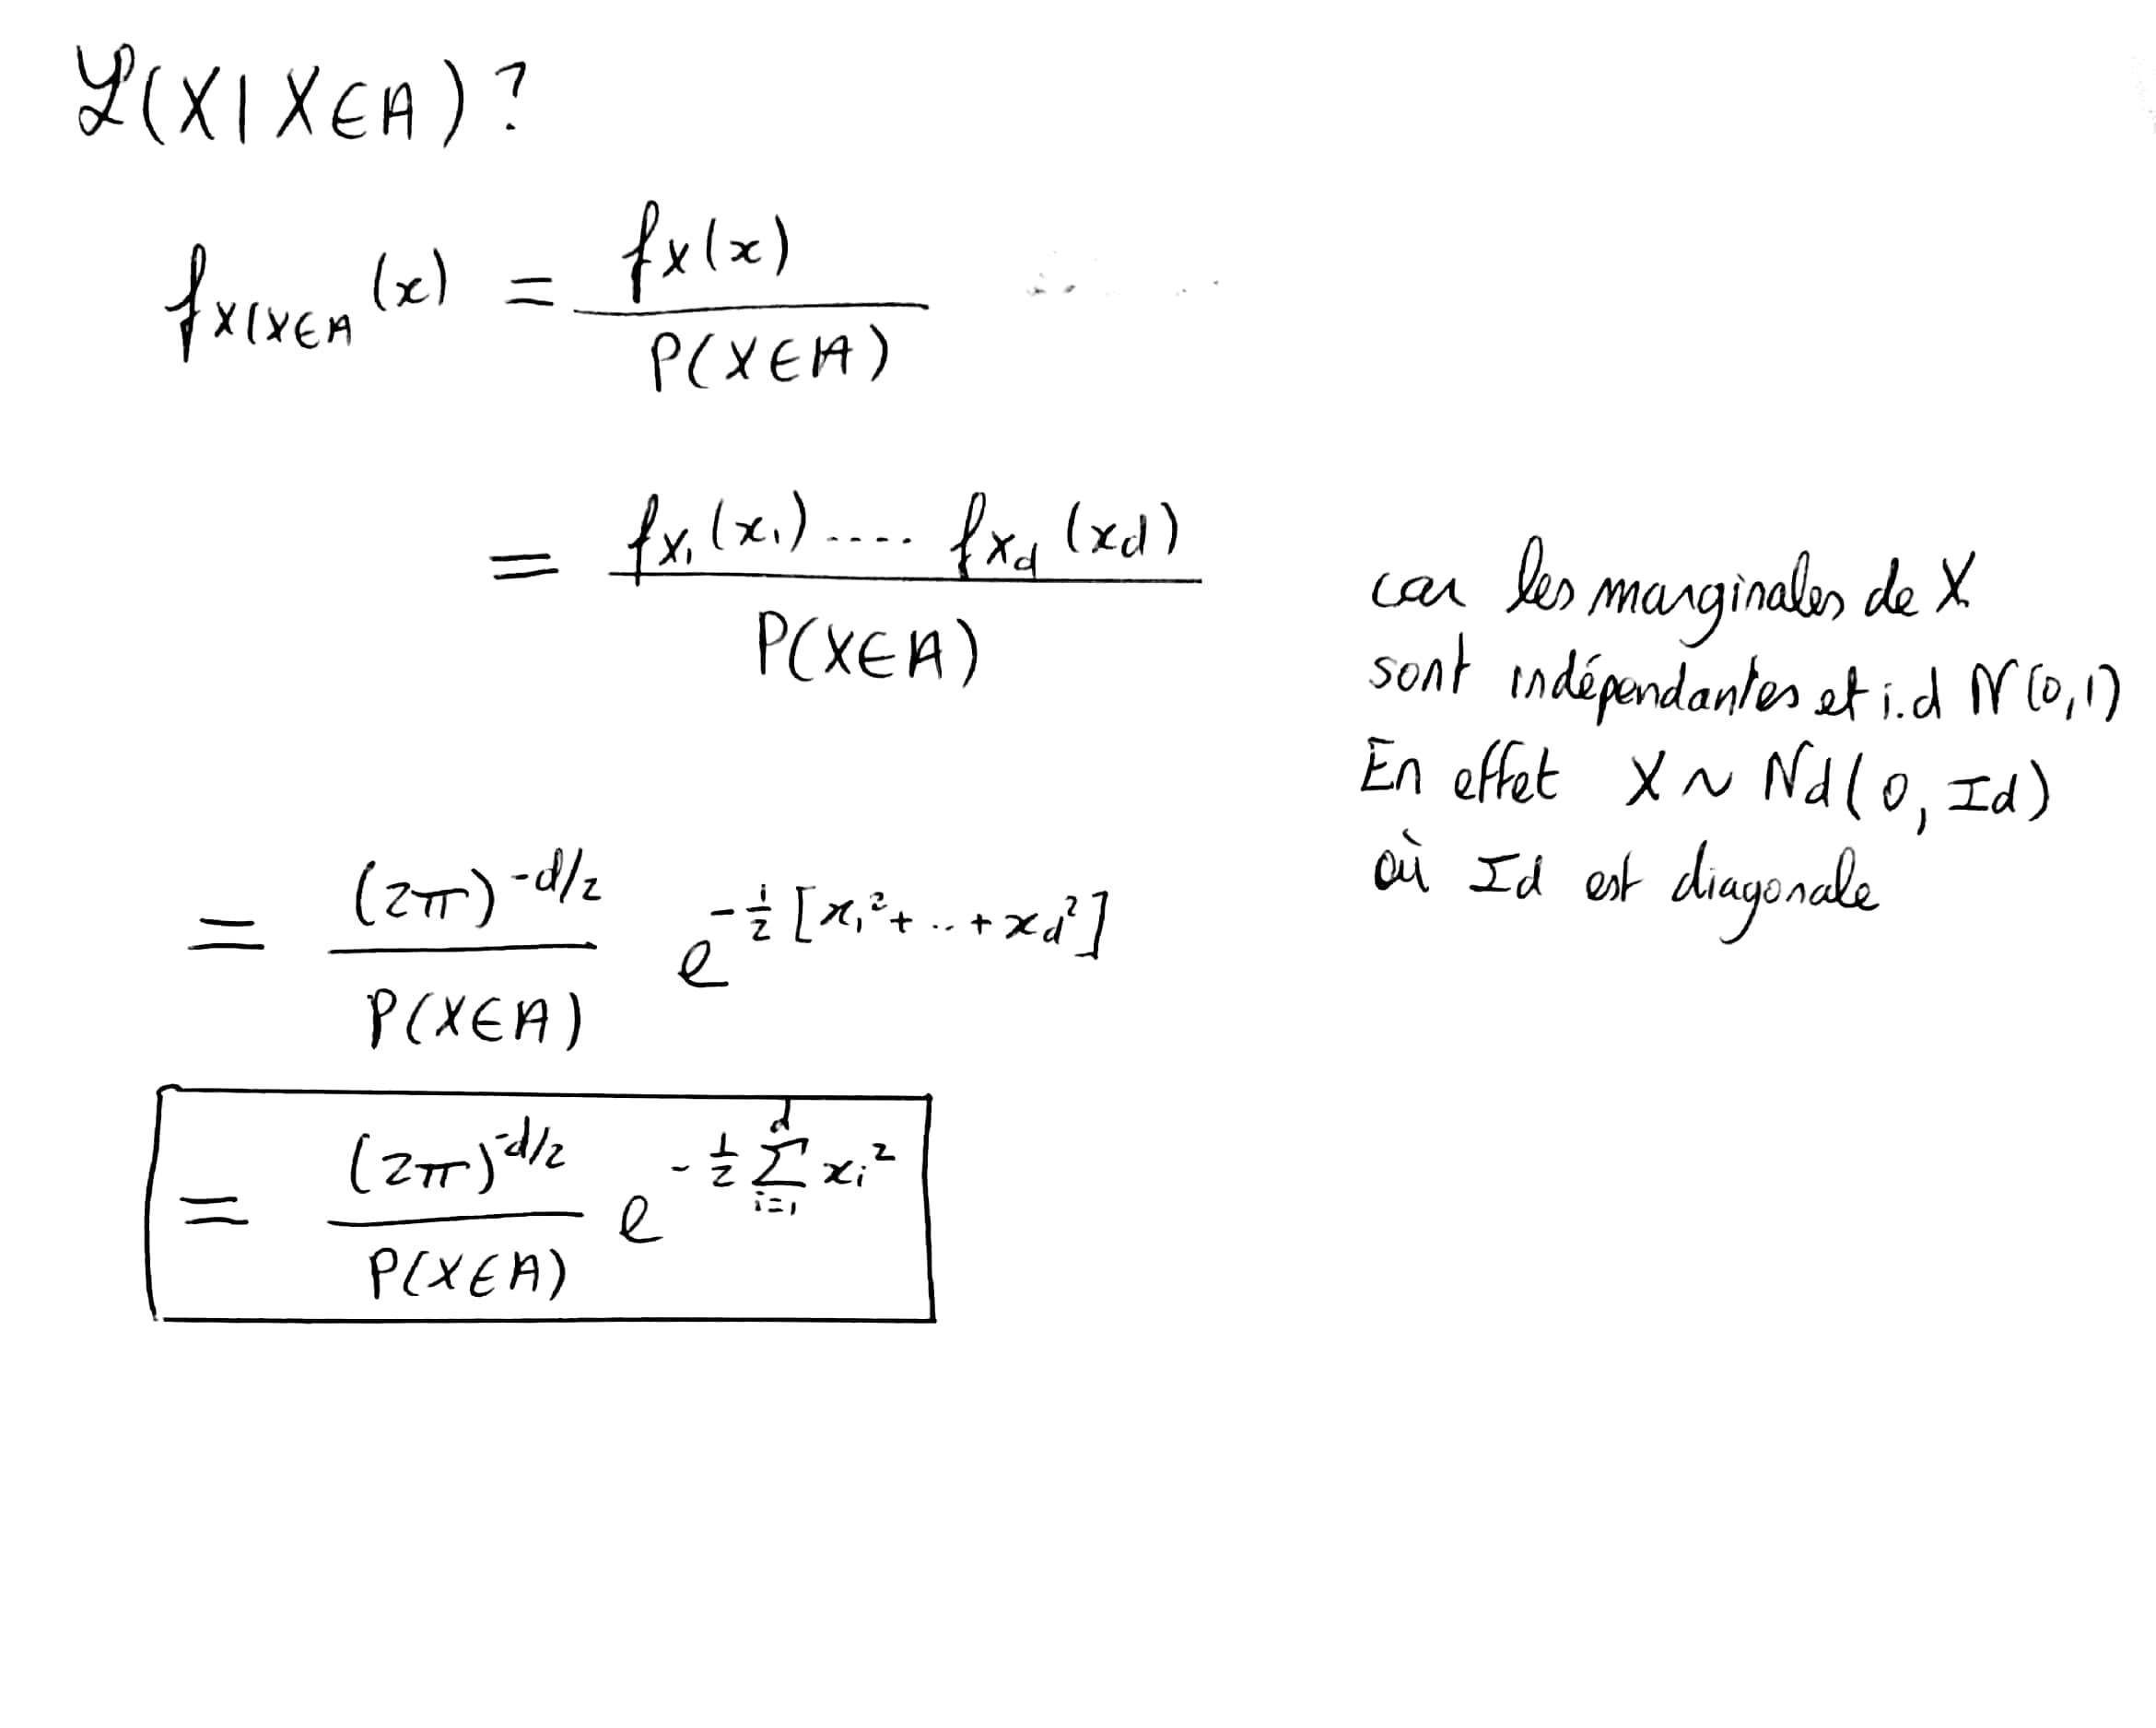

Programmons tout d'abord la méthode Monte Carlo qui va nous servir de comparaison

**code R :**

In [196]:
# monte carlo standard
library("mvtnorm")

phi <- function(x){
    # x : un vecteur de dimension 2
    return( log(1 + abs(x[1] - x[2])) )
}

monte_carlo_estimate <- function(n, d = 2, c = 0.5){
    # n : taille de l'échantillon
    # d : dimension (2 par default)
    # c le paramètre pour la région A (0.5 par default)
    
    rn <- rmvnorm(n, mean = rep(0,d), sigma = diag(d))
    index <- apply(rn, 1, function(x) abs(prod(x)) < c)
    rn <- rn[index, ]
    m <- nrow(rn)
    
    I_hat = 0
    if(m>0){
        for(i in 1:m){
            I_hat = I_hat + phi(rn[i,])
        }
        I_hat = I_hat / m
    }
    
    return(list(I_hat=I_hat, rate=m/n))
}

monte_carlo_estimate(100, d=2, c=0.01)

$I_hat
[1] 0.3400475

$rate
[1] 0.04

### 6.1.

Proposition de simulation :

1. simuler des $X_i \sim \mathcal{N}_d(0, I_d)$ 
2. calculer la moyenne $\hat\mu$ et la matrice de covariance empirique $\hat\Sigma$ des $X_i$ appartenant à $A$
3. faire de l'IS avec la loi auxiliaire $\mathcal{N}_d(\hat\mu, \hat\Sigma)$

calculer $\hat\mu$ et $\hat\Sigma$ est une mauvaise idée car ces termes sont encore des estimateurs de Monte-Carlo standard sur des événements rares lorsque le paramètre $c$ devient très petit ...

**code R :**

In [306]:
IS_gauss_estimate <- function(n, d = 2, c = 0.5){
    # etape 1
    X <- rmvnorm(n, mean = rep(0,d), sigma = diag(d))
    index <- apply(X, 1, function(x) abs(prod(x)) < c)
    X <- X[index, ]
    m <- nrow(X)

    # etape 2
    mu = apply(X, 2, mean)
    sig = cov(X)

    # etape 3
    Y = rmvnorm(n, mean = mu, sigma = sig)
    g = dmvnorm(Y, mu, sig)
    f = dmvnorm(Y, rep(0,d), diag(d))
    index <- apply(Y, 1, function(x) abs(prod(x)) > c)
    f[index] <- 0
    m <- sum(index)

    W = f / g
    phi_g = apply(Y, 1, phi)
    I_tilde = sum(phi_g * W) / sum(W)
    return(list(I_tilde=I_tilde, rate=(n-m)/n))
}

monte_carlo_estimate(10000, d=2, c=0.01)
IS_gauss_estimate(10000, d=2, c=0.01)

$I_hat
[1] 0.2822878

$rate
[1] 0.0355

$I_tilde
[1] 0.2872057

$rate
[1] 0.1485

### 6.2.

On change la loi auxiliaire / de proposition $g$ en prenant la **t-distribution** qui est plus épaisse aux bords qu'une gaussienne :

In [313]:
IS_t_estimate <- function(n, d=2, c=0.1, df=5){
    
    # simuler une t
    Y <- rmvt(n, sigma=diag(d), df=df)
    # calculer la densite de la loi t et celle de la gaussienne tronquee
    g <- dmvt(Y, delta = rep(0, d), sigma = diag(d), df = df)
    f <- dmvnorm(Y, rep(0,d), diag(d))
    index <- apply(Y, 1, function(x) abs(prod(x)) > c)
    f[index] <- 0
    m <- sum(index)

    W = f / g
    phi_g = apply(Y, 1, phi)
    I_tilde = sum(phi_g * W) / sum(W)
    return(list(I_tilde=I_tilde, rate=(n-m)/n))
}
                   
monte_carlo_estimate(2000, d=2, c=0.01)
IS_gauss_estimate(2000, d=2, c=0.01)
IS_t_estimate(2000, d=2, c=0.01)

$I_hat
[1] 0.2828123

$rate
[1] 0.039

$I_tilde
[1] 0.2247454

$rate
[1] 0.1335

$I_tilde
[1] 0.2522341

$rate
[1] 0.032

## Documentation sur Cross-Entropy

Je vous invite à regarder l'excellent papier suivant : [Cross-Entropy](https://www.researchgate.net/publication/279242256_Chapter_3_The_Cross-Entropy_Method_for_Optimization)